# 2D VAE toy

In [1]:
import keras
from keras import backend as K
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

from keras.layers import Input, Dense, Activation
from keras.layers import Flatten, Reshape, Lambda
from keras.utils import plot_model
from keras import Model

import os
import os.path as osp
import sys
sys.path.append('/home/jcollins')

import numpy as np
from scipy import linalg as LA

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def create_dir(dir_path):
    ''' Creates a directory (or nested directories) if they don't exist.
    '''
    if not osp.exists(dir_path):
        os.makedirs(dir_path)

    return dir_path

output_dir = './data/'

### Define VAE

In [71]:
def build_and_compile_vae(beta=1,
                          encoder = [512,256,128,64,32],
                          decoder = [512,256,128,64,32],
                          verbose=0,dropout=0,
                          optimizer=keras.optimizers.Adam()):
    
    def sampling(args):
        """Reparameterization trick by sampling fr an isotropic unit Gaussian.

        # Arguments
            args (tensor): mean and log of variance of Q(z|X)

        # Returns
            z (tensor): sampled latent vector
        """

        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    latent_dim = 2
    
    #Encoder
    inputs = Input(shape=(2,))
    layer = inputs
    for layer_size in encoder:
        layer = Dense(layer_size,activation='relu',bias_initializer='glorot_uniform')(layer)
        #layer = keras.layers.ReLU()(layer)
        if dropout > 0:
            layer = keras.layers.Dropout(dropout)(layer)
        

    #Bottleneck
    z_mean = Dense(latent_dim, name='z_mean')(layer)
    z_log_var = Dense(latent_dim, name='z_log_var')(layer)
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    if verbose:
        encoder.summary()
    #plot_model(encoder, to_file='CNN-VAE_encoder.png', show_shapes=True)

    #Decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    layer = latent_inputs
    
    for layer_size in decoder:
        layer = Dense(layer_size,activation='relu',bias_initializer='glorot_uniform')(layer)
        #layer = keras.layers.ReLU()(layer)
        if dropout > 0:
            layer = keras.layers.Dropout(dropout)(layer)
            
    decoded = Dense(2)(layer)

    decoder = Model(latent_inputs, decoded, name='decoder')
    if verbose:
        decoder.summary()
    #plot_model(decoder, to_file='CNN-VAE_decoder.png', show_shapes=True)


    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='CNN-VAE')

    def beta_vae_loss(beta):
        def vae_loss(x, x_decoded_mean):
            xent_loss = K.sqrt(K.sum(K.square(x - x_decoded_mean),axis=-1))
            kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
            return K.mean(xent_loss + beta * kl_loss)
        return vae_loss

    vae.compile(loss=beta_vae_loss(beta) , optimizer=optimizer)
    
    return vae, encoder, decoder

In [115]:
def plot_latent_space(encoder, valid_data):
    latent_valid = np.array(encoder.predict(valid_data))

    plt.figure(figsize=(18,4))

    plt.subplot(1,3,1)
    plt.hist(latent_valid[0,:,0],bins=np.arange(-5,5.00001,0.1),label="latent dimension 1",alpha=0.75)
    plt.hist(latent_valid[0,:,1],bins=np.arange(-5,5.00001,0.1),label="latent dimension 2",alpha=0.75)
    plt.title("latent means")
    plt.xlim([-5,5])
    plt.legend()

    plt.subplot(1,3,2)
    plt.hist(latent_valid[1,:,0],bins=np.arange(-15,1,0.1),label="latent dimension 1",alpha=0.75)
    plt.hist(latent_valid[1,:,1],bins=np.arange(-15,1,0.1),label="latent dimension 2",alpha=0.75)
    plt.title("latent log(variance)")
    plt.xlim([-15,1])
    plt.legend()

    plt.subplot(1,3,3)
    plt.hist(latent_valid[2,:,0],bins=np.arange(-5,5.00001,0.1),label="latent dimension 1",alpha=0.75)
    plt.hist(latent_valid[2,:,1],bins=np.arange(-5,5.00001,0.1),label="latent dimension 2",alpha=0.75)
    plt.title("sampled z")
    plt.xlim([-5,5])
    plt.legend()

    plt.show()
    
def plot_latent_map(decoder, train_data_banana, long_axis=0,
                    long_scale = [-4,4],
                    short_values = [-1,0,1]):
    long_range = long_scale[1]-long_scale[0]
    codes = np.arange(long_scale[0],long_scale[1],0.01)
    if long_axis == 0:
        codes0 = np.array([[code,short_values[0]] for code in codes])
        codes1 = np.array([[code,short_values[1]] for code in codes])
        codes2 = np.array([[code,short_values[2]] for code in codes])
    else:
        codes0 = np.array([[short_values[0],code] for code in codes])
        codes1 = np.array([[short_values[1],code] for code in codes])
        codes2 = np.array([[short_values[2],code] for code in codes])
        
    points = np.zeros((int(long_range/0.01),2))
    points = decoder.predict(codes0)

    plt.scatter(train_data_banana[:,0],train_data_banana[:,1],color='gray',alpha=0.2,s=0.1)
    plt.scatter(points[:,0],points[:,1],label=("latent axis " + str(1-long_axis) + " = " + str(short_values[0])),s=0.5)

    points = np.zeros((int(long_range/0.01),2))
    points = decoder.predict(codes1)
    plt.scatter(points[:,0],points[:,1],label=("latent axis " + str(1-long_axis) + " = " + str(short_values[1])),s=0.5)

    points = np.zeros((int(long_range/0.01),2))
    points = decoder.predict(codes2)
    plt.scatter(points[:,0],points[:,1],label=("latent axis " + str(1-long_axis) + " = " + str(short_values[2])),s=0.5)
    plt.xlim([-3.5,3.5])
    plt.ylim([-0.5,2])
    plt.legend()

    plt.show()

## Generate training data

Input data is 2D, generated in the shape of a banana (plotted below) defined by two gaussians with widths 1 and 0.1. The VAE will be tasked with reconstructing the 2D location of the input points, using euclidean distance as the reconstruction error. The latent space is 2D, so can in principle easily encode everything about the input. This will be regulated by the variational latent space

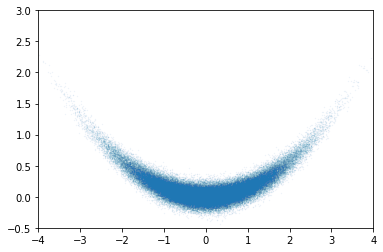

In [5]:
numtrain = 100000
numvalid = 10000

train_data = np.random.normal(scale=(1,0.1),size=(numtrain,2))
train_data[:,1] = train_data[:,1]+train_data[:,0]*train_data[:,0]/7
valid_data = np.random.normal(scale=(1,0.1),size=(numvalid,2))
valid_data[:,1] = valid_data[:,1]+valid_data[:,0]*valid_data[:,0]/7

plt.scatter(train_data[:,0],train_data[:,1],s=0.1,alpha=0.1)
plt.xlim([-4,4])
plt.ylim([-0.5,3])
plt.show()

# Beta-VAE experiments

## beta = 0.001
In the limit of small beta, the vae behaves like an AE because the KL term is not given significant weight. It is not to be expected that the latent space directions will be so well behaved.

In [21]:
experiment_name = '2D-VAE-beta0.001'
vae, encoder, decoder = build_and_compile_vae(beta=0.001,
                                             optimizer=keras.optimizers.Adam(lr=0.001))

save_period = 10
epochs = 10

train_output_dir = create_dir(osp.join(output_dir, experiment_name))
modelcheckpoint = keras.callbacks.ModelCheckpoint(train_output_dir + '/model_{epoch:02d}-{val_loss:.2e}.hdf5', period = save_period)

callbacks = [modelcheckpoint]

history = vae.fit(x=train_data, y=train_data, batch_size=100,
                epochs=epochs,verbose=1,
                validation_data = (valid_data,valid_data),
                callbacks = callbacks
              )

Train on 100000 samples, validate on 10000 samples
Epoch 1/10
100000/100000 [==============================] - 12s 118us/step - loss: 0.0988 - val_loss: 0.0404
Epoch 2/10
100000/100000 [==============================] - 10s 103us/step - loss: 0.0340 - val_loss: 0.0241
Epoch 3/10
100000/100000 [==============================] - 10s 103us/step - loss: 0.0277 - val_loss: 0.0233
Epoch 4/10
100000/100000 [==============================] - 10s 104us/step - loss: 0.0243 - val_loss: 0.0324
Epoch 5/10
100000/100000 [==============================] - 10s 103us/step - loss: 0.0237 - val_loss: 0.0170
Epoch 6/10
100000/100000 [==============================] - 10s 103us/step - loss: 0.0218 - val_loss: 0.0255
Epoch 7/10
100000/100000 [==============================] - 10s 102us/step - loss: 0.0216 - val_loss: 0.0216
Epoch 8/10
100000/100000 [==============================] - 10s 103us/step - loss: 0.0201 - val_loss: 0.0171
Epoch 9/10
100000/100000 [==============================] - 10s 102us/step - 

Latent space encoding for beta = 0.001:


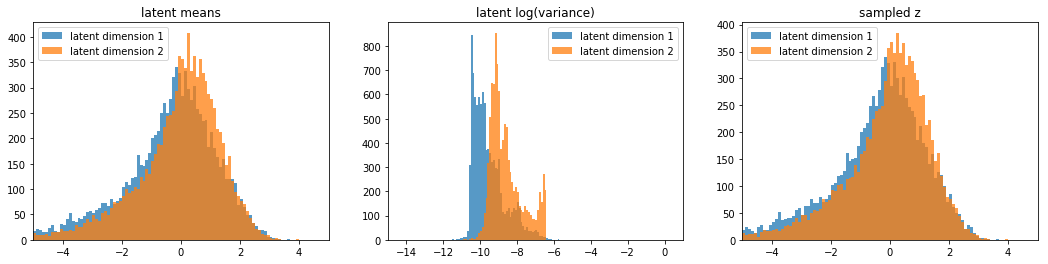

In [23]:
print("Latent space encoding for beta = 0.001:")
plot_latent_space(encoder,valid_data)

We see from the rightmost plot especially that the latent space is not well regulated. There doesn't seem to be much useful information in the middle plot.

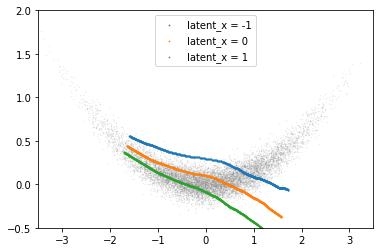

In [22]:
plot_latent_map(decoder,valid_data,long_axis=0)

The VAE is behaving like an AE. The NN has learnt some mapping between the latent space and the real space, but it is random and arbitrary. 

## beta = 0.01

In [155]:
experiment_name = '2D-VAE-beta0.01'
vae, encoder, decoder = build_and_compile_vae(beta=0.01,
                                              encoder=[256,128,64,64,32],
                                              decoder=[256,128,64,64,32],
                                             optimizer=keras.optimizers.Adam(lr=0.001))

save_period = 10
epochs = 20

train_output_dir = create_dir(osp.join(output_dir, experiment_name))
modelcheckpoint = keras.callbacks.ModelCheckpoint(train_output_dir + '/model_{epoch:02d}-{val_loss:.2e}.hdf5', period = save_period)

callbacks = [modelcheckpoint]

history = vae.fit(x=train_data, y=train_data, batch_size=100,
                epochs=epochs,verbose=1,
                validation_data = (valid_data,valid_data),
                callbacks = callbacks
              )

Train on 100000 samples, validate on 10000 samples
Epoch 1/20
100000/100000 [==============================] - 19s 188us/step - loss: 0.1375 - val_loss: 0.1152
Epoch 2/20
100000/100000 [==============================] - 12s 123us/step - loss: 0.1067 - val_loss: 0.1050
Epoch 3/20
100000/100000 [==============================] - 12s 122us/step - loss: 0.1064 - val_loss: 0.1109
Epoch 4/20
100000/100000 [==============================] - 12s 123us/step - loss: 0.1057 - val_loss: 0.1052
Epoch 5/20
100000/100000 [==============================] - 12s 122us/step - loss: 0.1051 - val_loss: 0.1048
Epoch 6/20
100000/100000 [==============================] - 12s 123us/step - loss: 0.1053 - val_loss: 0.1037
Epoch 7/20
100000/100000 [==============================] - 12s 123us/step - loss: 0.1051 - val_loss: 0.1026
Epoch 8/20
100000/100000 [==============================] - 12s 122us/step - loss: 0.1044 - val_loss: 0.1067
Epoch 9/20
100000/100000 [==============================] - 12s 123us/step - 

Latent space encoding for beta = 0.01:


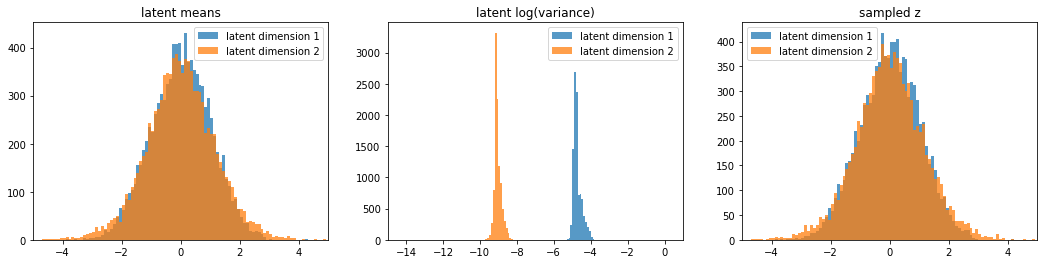

In [158]:
print("Latent space encoding for beta = 0.01:")
plot_latent_space(encoder,valid_data)

Latent space mapping for beta = 0.01:


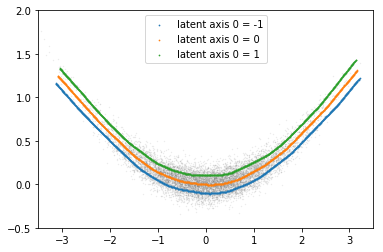

In [159]:
print("Latent space mapping for beta = 0.01:")
plot_latent_map(decoder,valid_data,long_axis=1)

The VAE is well regulated, and the two latent space axes represent the two principal directions of variation in the data. There are two sharp peaks in the plot of log(variance) of the latent variables, and -9, and -5. These latent axes correspond to the long and short directions of the banana respectively. The locations of these peaks are very meaningful. There is a relation that can be deduced from inspection of the loss function. If there is a well defined length scale in the real space problem, then this will be encoded in a latent direction with variance given by L = beta / sigma, where L is the length scale, beta is the KL weight and sigma is sqrt of the variance. The peaks at around -9 and -5 map to L - 1 and 0.1 respectively. We can deduce from that that the orange latent dimension (dimension 1) corresponds to the length of the banan (which has size of order 1) while latent dimension 0 will correspond with the girth of the banana that has characteristic size of 0.1. This is established in the play above which maps the latent directions into real space.

It is therefore possible to do spectroscopy of the lengthscales in the problem by looking for peaks in the distribution of variances. At least it is true in this simple toy example.

A dimension becomes marginal when it is being encoded with log var ~ -1. At this point the VAE is barely able to resolve the dimension. From the plot of log variance above, I deduce that the girth of the banana will become marginal at around beta = 0.01*exp(4/2) ~ 1.

## beta = 0.1

In [160]:
experiment_name = '2D-VAE-beta0.1'
vae, encoder, decoder = build_and_compile_vae(beta=0.1,
                                              encoder=[256,128,64,64,32],
                                              decoder=[256,128,64,64,32],
                                             optimizer=keras.optimizers.Adam(lr=0.001))

save_period = 10
epochs = 20

train_output_dir = create_dir(osp.join(output_dir, experiment_name))
modelcheckpoint = keras.callbacks.ModelCheckpoint(train_output_dir + '/model_{epoch:02d}-{val_loss:.2e}.hdf5', period = save_period)

callbacks = [modelcheckpoint]

history = vae.fit(x=train_data, y=train_data, batch_size=100,
                epochs=epochs,verbose=1,
                validation_data = (valid_data,valid_data),
                callbacks = callbacks
              )

Train on 100000 samples, validate on 10000 samples
Epoch 1/20
100000/100000 [==============================] - 19s 189us/step - loss: 0.2783 - val_loss: 0.2472
Epoch 2/20
100000/100000 [==============================] - 12s 124us/step - loss: 0.2464 - val_loss: 0.2462
Epoch 3/20
100000/100000 [==============================] - 12s 122us/step - loss: 0.2453 - val_loss: 0.2416
Epoch 4/20
100000/100000 [==============================] - 13s 125us/step - loss: 0.2445 - val_loss: 0.2458
Epoch 5/20
100000/100000 [==============================] - 12s 123us/step - loss: 0.2443 - val_loss: 0.2426
Epoch 6/20
100000/100000 [==============================] - 12s 122us/step - loss: 0.2441 - val_loss: 0.2460
Epoch 7/20
100000/100000 [==============================] - 12s 123us/step - loss: 0.2435 - val_loss: 0.2444
Epoch 8/20
100000/100000 [==============================] - 12s 124us/step - loss: 0.2436 - val_loss: 0.2431
Epoch 9/20
100000/100000 [==============================] - 13s 125us/step - 

Latent space encoding for beta = 0.1:


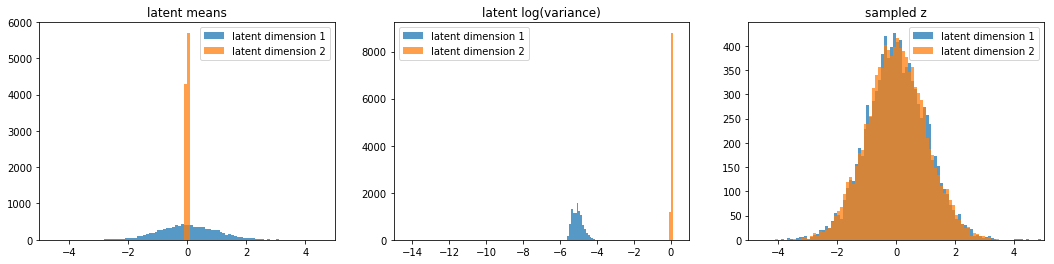

In [161]:
print("Latent space encoding for beta = 0.1:")
plot_latent_space(encoder,valid_data)

Latent space mapping for beta = 0.1:


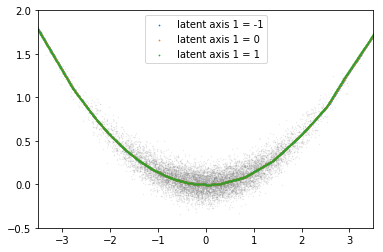

In [163]:
print("Latent space mapping for beta = 0.1:")
plot_latent_map(decoder,valid_data,long_axis=0)

It looks like the girth can no longer be resolved. It should still be resolvable though. The ratio in the sizes of the two dimensions is a factor 10. In the variance plot, blue peaks at -5, so orange should peak at -5 + Log(100) = -0.5, but instead it has been completely pushed to 0. All points are being decoded to an average value along the girth, but still have some prediction along the length.

Actually, this is a consequence of falling in a bad local minimum. There is frequently a local minumum when a latent space variable encodes nothing (satisfying the KL term), and it seems to be very difficult to escape from. I actually had to train the beta = 0.01 example many times, since it would frequently not learn the girth. I will show later that the girth is still barely resolvable at beta = 0.1 using beta-annealing.

## beta = 1

In [66]:
experiment_name = '2D-VAE-beta1'
vae, encoder, decoder = build_and_compile_vae(beta=1.,
                                              encoder=[256,128,64,64,32],
                                              decoder=[256,128,64,64,32],
                                             optimizer=keras.optimizers.Adam(lr=0.001))

save_period = 10
epochs = 10

train_output_dir = create_dir(osp.join(output_dir, experiment_name))
modelcheckpoint = keras.callbacks.ModelCheckpoint(train_output_dir + '/model_{epoch:02d}-{val_loss:.2e}.hdf5', period = save_period)

callbacks = [modelcheckpoint]

history = vae.fit(x=train_data, y=train_data, batch_size=100,
                epochs=epochs,verbose=1,
                validation_data = (valid_data,valid_data),
                callbacks = callbacks
              )

Train on 100000 samples, validate on 10000 samples
Epoch 1/10
100000/100000 [==============================] - 17s 166us/step - loss: 0.7658 - val_loss: 0.7630
Epoch 2/10
100000/100000 [==============================] - 12s 122us/step - loss: 0.7568 - val_loss: 0.7556
Epoch 3/10
100000/100000 [==============================] - 12s 123us/step - loss: 0.7561 - val_loss: 0.7597
Epoch 4/10
100000/100000 [==============================] - 12s 121us/step - loss: 0.7573 - val_loss: 0.7566
Epoch 5/10
100000/100000 [==============================] - 12s 122us/step - loss: 0.7560 - val_loss: 0.7628
Epoch 6/10
100000/100000 [==============================] - 12s 121us/step - loss: 0.7525 - val_loss: 0.7582
Epoch 7/10
100000/100000 [==============================] - 12s 122us/step - loss: 0.7563 - val_loss: 0.7551
Epoch 8/10
100000/100000 [==============================] - 12s 121us/step - loss: 0.7559 - val_loss: 0.7593
Epoch 9/10
100000/100000 [==============================] - 12s 123us/step - 

Latent space encoding for beta = 1:


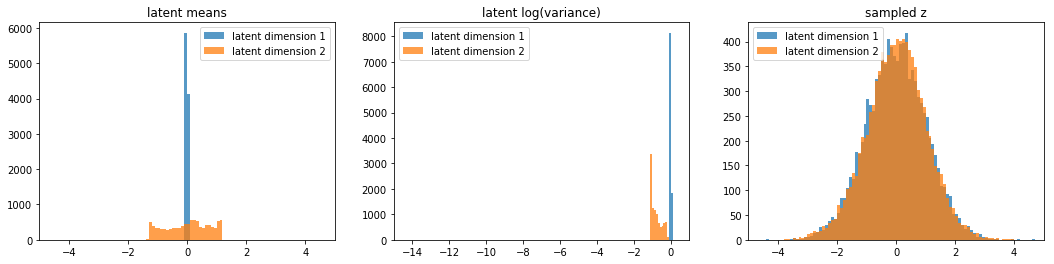

In [67]:
print("Latent space encoding for beta = 1:")
plot_latent_space(encoder,valid_data)

beta = 1


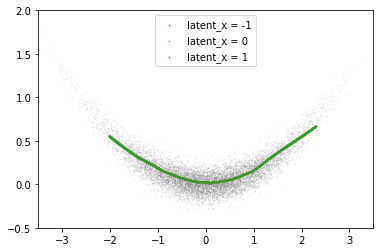

In [68]:
print("beta = 1")
plot_latent_map(decoder,valid_data,long_axis=1)

The short dimension is long gone and the long dimension is becoming marginal. The resolution in the long direction is O(1) and all points are being mapped to an average location along the girth.

## beta = 3

In [72]:
experiment_name = '2D-VAE-beta3'
vae, encoder, decoder = build_and_compile_vae(beta=3.,
                                              encoder=[256,128,64,64,32],
                                              decoder=[256,128,64,64,32],
                                             optimizer=keras.optimizers.Adam(lr=0.001))

save_period = 10
epochs = 10

train_output_dir = create_dir(osp.join(output_dir, experiment_name))
modelcheckpoint = keras.callbacks.ModelCheckpoint(train_output_dir + '/model_{epoch:02d}-{val_loss:.2e}.hdf5', period = save_period)

callbacks = [modelcheckpoint]

history = vae.fit(x=train_data, y=train_data, batch_size=100,
                epochs=epochs,verbose=1,
                validation_data = (valid_data,valid_data),
                callbacks = callbacks
              )

Train on 100000 samples, validate on 10000 samples
Epoch 1/10
100000/100000 [==============================] - 17s 168us/step - loss: 0.8272 - val_loss: 0.8264
Epoch 2/10
100000/100000 [==============================] - 12s 122us/step - loss: 0.8220 - val_loss: 0.8270
Epoch 3/10
100000/100000 [==============================] - 12s 122us/step - loss: 0.8218 - val_loss: 0.8270
Epoch 4/10
100000/100000 [==============================] - 12s 123us/step - loss: 0.8218 - val_loss: 0.8269
Epoch 5/10
100000/100000 [==============================] - 12s 122us/step - loss: 0.8219 - val_loss: 0.8272
Epoch 6/10
100000/100000 [==============================] - 12s 123us/step - loss: 0.8217 - val_loss: 0.8264
Epoch 7/10
100000/100000 [==============================] - 12s 121us/step - loss: 0.8216 - val_loss: 0.8266
Epoch 8/10
100000/100000 [==============================] - 12s 123us/step - loss: 0.8215 - val_loss: 0.8264
Epoch 9/10
100000/100000 [==============================] - 12s 123us/step - 

Latent space encoding for beta = 1:


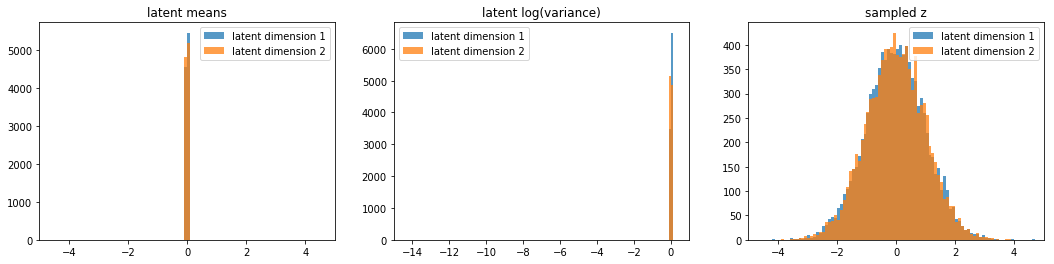

In [73]:
print("Latent space encoding for beta = 1:")
plot_latent_space(encoder,valid_data)

beta = 1


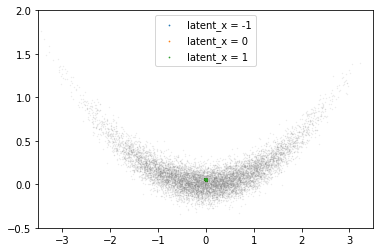

In [74]:
print("beta = 1")
plot_latent_map(decoder,valid_data,long_axis=1)

The long dimension is now also unresolvable. The encoder chooses to encode no information about the input into the latent space. The decoder has learnt to ignore the latent space, and to map everything to an average point in the real space.

### Commentary

Beta sets the resolution for the VAE, and the VAE may not resolve information below the scale set by beta. So for beta above 0.1, the VAE cannot resolve the dimension with typical size 0.1. For beta above 1, it cannot resolve the dimension with typical size 1.

For very small beta (compared to the length scales of interest), the VAE behaves like an AE. It encodes all the information it can into the latent space, but in a way that is not regulated and is difficult to interpret. As beta becomes marginal for some axes of variation, some latent space dimensions begin to align with those axes. If the length scales are sharp (as they are in this toy dataset), the distribution of encoded variances forms a peak that maps directly to the corresponding length scale, allowing you to perform spectroscopy.

The latent space should be as large as possible. It is beta that forces a dimensional reduction. For 0.1 < beta < 1, the latent space was in principle 2D, but it was clear that only one of them was encoding information. By using beta instead of the number of latent dimensions to control the dimensional reduction, we are encouraging the VAE to organise information hierarchically according to importance (where importance is defined only with respect to that metric that is used for defining the reconstruction loss).

When beta is marginal, it becomes very difficult to train the VAE as it falls into local minima where it is discarding information that would actually be encoded in the global minimum. This is fixed with beta annealing below

# Beta annealing

The idea is to start training at very small beta, so the VAE learns to encode a poorly regulated but high-information encoding of the information into the latent space. As you then increase beta, the latent directions become well regulated and begin to align with axes of variance present in the training dataset. Dimensions will only be forgetten when beta truly crosses over the threshold of marginality.

In [164]:
def build_and_compile_annealing_vae(encoder = [512,256,128,64,32],
                                    decoder = [512,256,128,64,32],
                                    verbose=0,dropout=0,
                                    optimizer=keras.optimizers.Adam()):
    
    def sampling(args):
        """Reparameterization trick by sampling fr an isotropic unit Gaussian.

        # Arguments
            args (tensor): mean and log of variance of Q(z|X)

        # Returns
            z (tensor): sampled latent vector
        """

        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    latent_dim = 2
    
    #Encoder
    inputs = Input(shape=(2,))
    beta_input = Input(shape=(1,))
    layer = inputs
    for layer_size in encoder:
        layer = Dense(layer_size,bias_initializer='glorot_uniform')(layer)
        layer = keras.layers.ReLU()(layer)
        if dropout > 0:
            layer = keras.layers.Dropout(dropout)(layer)
        

    #Bottleneck
    z_mean = Dense(latent_dim, name='z_mean')(layer)
    z_log_var = Dense(latent_dim, name='z_log_var')(layer)
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    if verbose:
        encoder.summary()
    #plot_model(encoder, to_file='CNN-VAE_encoder.png', show_shapes=True)

    #Decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    layer = latent_inputs
    
    for layer_size in decoder:
        layer = Dense(layer_size,bias_initializer='glorot_uniform')(layer)
        layer = keras.layers.ReLU()(layer)
        if dropout > 0:
            layer = keras.layers.Dropout(dropout)(layer)
            
    decoded = Dense(2)(layer)

    decoder = Model(latent_inputs, decoded, name='decoder')
    if verbose:
        decoder.summary()
    #plot_model(decoder, to_file='CNN-VAE_decoder.png', show_shapes=True)


    outputs = decoder(encoder(inputs)[2])
    vae = Model([inputs,beta_input], outputs, name='CNN-VAE')

    def beta_vae_loss(beta):
        def vae_loss(x, x_decoded_mean):
            xent_loss = K.sqrt(K.sum(K.square(x - x_decoded_mean),axis=-1))
            kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
            return K.mean(xent_loss + beta * kl_loss)
        return vae_loss

    vae.compile(loss=beta_vae_loss(beta_input) , optimizer=optimizer)
    
    return vae, encoder, decoder

### First train a few epochs at very small beta
### beta = 0.00001

In [98]:
experiment_name = '2D-VAE-beta-anneal'
vae, encoder, decoder = build_and_compile_annealing_vae(encoder=[256,128,64,64,32],
                                                        decoder=[256,128,64,64,32],
                                                        optimizer=keras.optimizers.Adam(lr=0.001))

save_period = 10
epochs = 5

train_output_dir = create_dir(osp.join(output_dir, experiment_name))
modelcheckpoint = keras.callbacks.ModelCheckpoint(train_output_dir + '/model_{epoch:02d}-{val_loss:.2e}.hdf5', period = save_period)

callbacks = [modelcheckpoint]

beta=0.00001 

history = vae.fit(x=[train_data,np.ones(numtrain)*beta], y=train_data, batch_size=100,
                epochs=epochs,verbose=1,
                validation_data = ([valid_data,np.ones(numvalid)*beta],valid_data),
                callbacks = callbacks
              )

Train on 100000 samples, validate on 10000 samples
Epoch 1/5
100000/100000 [==============================] - 19s 190us/step - loss: 0.1078 - val_loss: 0.0834
Epoch 2/5
100000/100000 [==============================] - 13s 131us/step - loss: 0.0355 - val_loss: 0.0240
Epoch 3/5
100000/100000 [==============================] - 13s 131us/step - loss: 0.0205 - val_loss: 0.0110
Epoch 4/5
100000/100000 [==============================] - 13s 130us/step - loss: 0.0179 - val_loss: 0.0324
Epoch 5/5
100000/100000 [==============================] - 13s 132us/step - loss: 0.0168 - val_loss: 0.0120


Latent space encoding for beta = 1e-05 :


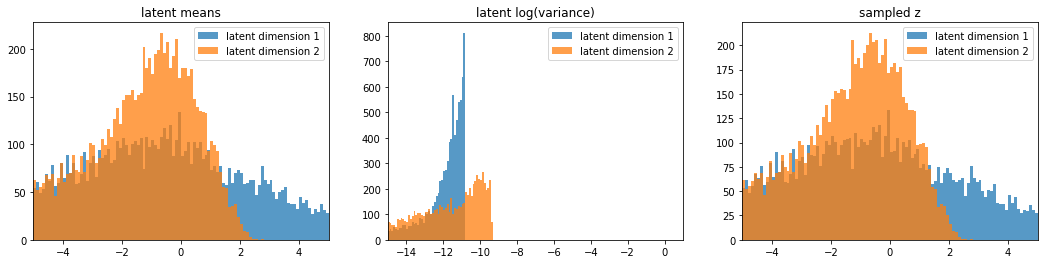

In [101]:
print("Latent space encoding for beta =",beta,":")
plot_latent_space(encoder,valid_data)

Latent distribution


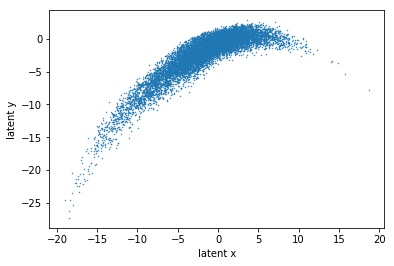

In [113]:
codes = encoder.predict(valid_data)
plt.scatter(codes[2][:,0],codes[2][:,1],s=0.2)
plt.xlabel("latent x")
plt.ylabel("latent y")
print("Latent distribution")
plt.show()

Latent space mapping for beta =  1e-05 :


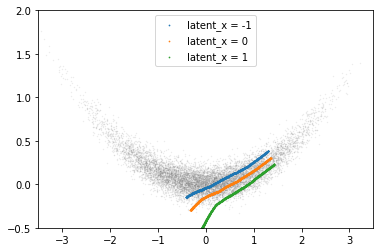

In [114]:
print("Latent space mapping for beta = ",beta,":")
plot_latent_map(decoder,valid_data,long_axis=0)

Clearly a poorly regulated latent space.

### beta = 0.0001

Now train for one epoch with factor 10 higher beta

In [116]:
beta = 0.0001
history = vae.fit(x=[train_data,np.ones(len(train_data))*beta], y=train_data, batch_size=100,
                epochs=1,verbose=1,
                validation_data = ([valid_data,np.ones(len(valid_data))*beta],valid_data),
                callbacks = callbacks
              )

Train on 100000 samples, validate on 10000 samples
Epoch 1/1
100000/100000 [==============================] - 13s 131us/step - loss: 0.0161 - val_loss: 0.0198


Latent space encoding for beta = 0.0001 :


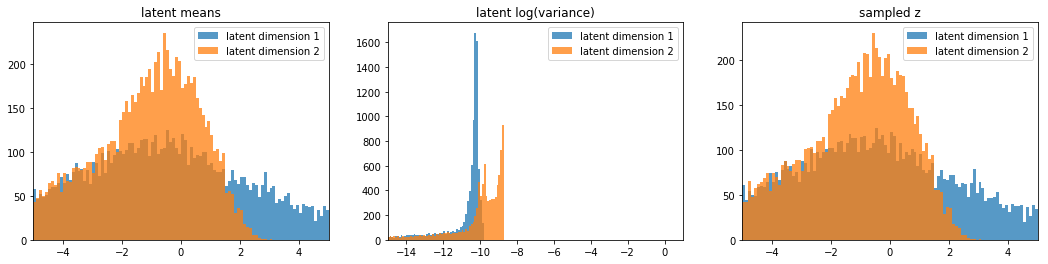

In [117]:
print("Latent space encoding for beta =",beta,":")
plot_latent_space(encoder,valid_data)

Latent distribution


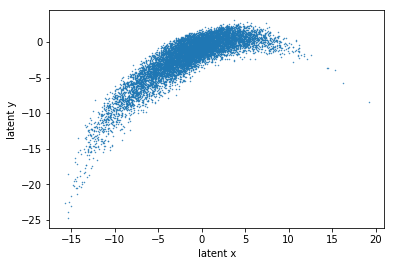

In [118]:
codes = encoder.predict(valid_data)
plt.scatter(codes[2][:,0],codes[2][:,1],s=0.2)
plt.xlabel("latent x")
plt.ylabel("latent y")
print("Latent distribution")
plt.show()

Latent space mapping for beta =  0.0001 :


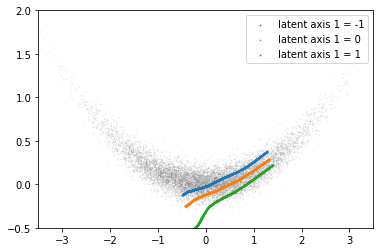

In [119]:
print("Latent space mapping for beta = ",beta,":")
plot_latent_map(decoder,valid_data,long_axis=0)

Still not regulated

### beta = 0.001

Train one more epoch at higher beta

In [120]:
beta = 0.001
history = vae.fit(x=[train_data,np.ones(len(train_data))*beta], y=train_data, batch_size=100,
                epochs=1,verbose=1,
                validation_data = ([valid_data,np.ones(len(valid_data))*beta],valid_data),
                callbacks = callbacks
              )

Train on 100000 samples, validate on 10000 samples
Epoch 1/1
100000/100000 [==============================] - 13s 129us/step - loss: 0.0229 - val_loss: 0.0196


Latent space encoding for beta = 0.001 :


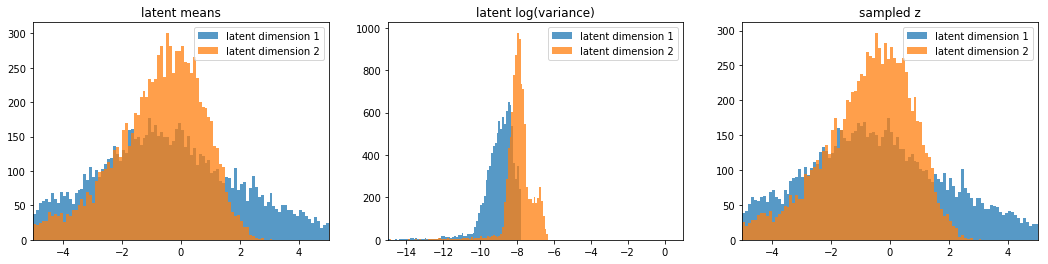

In [121]:
print("Latent space encoding for beta =",beta,":")
plot_latent_space(encoder,valid_data)

Latent distribution


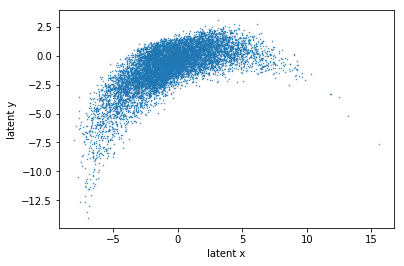

In [122]:
codes = encoder.predict(valid_data)
plt.scatter(codes[2][:,0],codes[2][:,1],s=0.2)
plt.xlabel("latent x")
plt.ylabel("latent y")
print("Latent distribution")
plt.show()

Latent space mapping for beta =  0.001 :


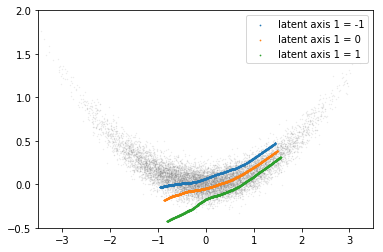

In [124]:
print("Latent space mapping for beta = ",beta,":")
plot_latent_map(decoder,valid_data,long_axis=0)

Still not regulated.

### beta = 0.01

Train one epoch at higher beta

In [125]:
beta = 0.01
history = vae.fit(x=[train_data,np.ones(len(train_data))*beta], y=train_data, batch_size=100,
                epochs=1,verbose=1,
                validation_data = ([valid_data,np.ones(len(valid_data))*beta],valid_data),
                callbacks = callbacks
              )

Train on 100000 samples, validate on 10000 samples
Epoch 1/1
100000/100000 [==============================] - 13s 127us/step - loss: 0.0599 - val_loss: 0.0571


Latent space encoding for beta = 0.01 :


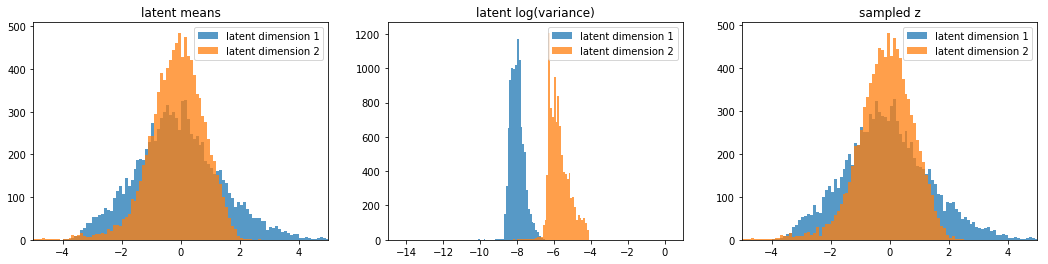

In [126]:
print("Latent space encoding for beta =",beta,":")
plot_latent_space(encoder,valid_data)

Latent distribution


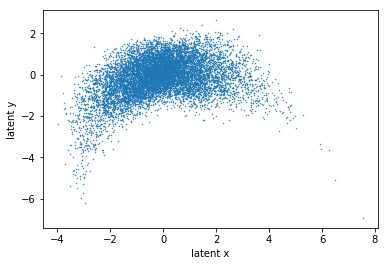

In [127]:
codes = encoder.predict(valid_data)
plt.scatter(codes[2][:,0],codes[2][:,1],s=0.2)
plt.xlabel("latent x")
plt.ylabel("latent y")
print("Latent distribution")
plt.show()

Latent space mapping for beta =  0.01 :


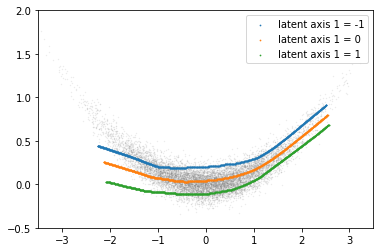

In [129]:
print("Latent space mapping for beta = ",beta,":")
plot_latent_map(decoder,valid_data,long_axis=0)

The latent space is starting to become regulated, as can be seen manifested in all five plots above. Maybe it would have been even better if I trained for more than one epoch.

### beta = 0.03

Increase by a factor of only 3 this time because it is starting to get interesting

In [135]:
beta = 0.03
history = vae.fit(x=[train_data,np.ones(len(train_data))*beta], y=train_data, batch_size=100,
                epochs=1,verbose=1,
                validation_data = ([valid_data,np.ones(len(valid_data))*beta],valid_data),
                callbacks = callbacks
              )

Train on 100000 samples, validate on 10000 samples
Epoch 1/1
100000/100000 [==============================] - 13s 130us/step - loss: 0.1163 - val_loss: 0.1160


Latent space encoding for beta = 0.03 :


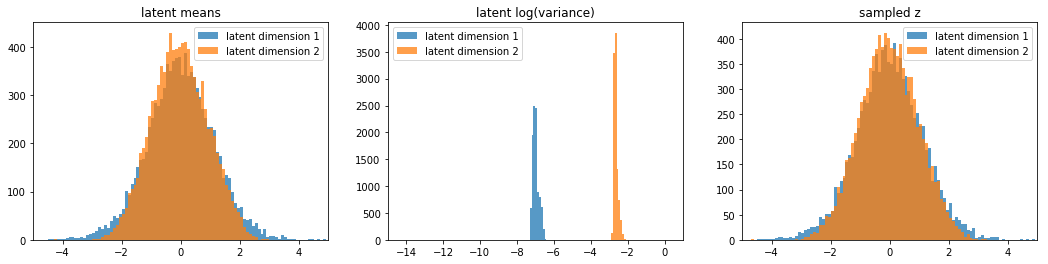

In [136]:
print("Latent space encoding for beta =",beta,":")
plot_latent_space(encoder,valid_data)

Latent distribution


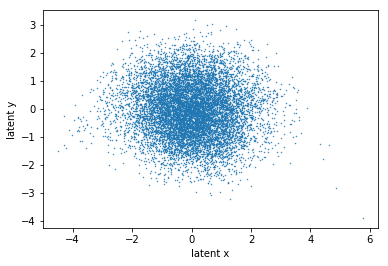

In [137]:
codes = encoder.predict(valid_data)
plt.scatter(codes[2][:,0],codes[2][:,1],s=0.2)
plt.xlabel("latent x")
plt.ylabel("latent y")
print("Latent distribution")
plt.show()

Latent space mapping for beta =  0.03 :


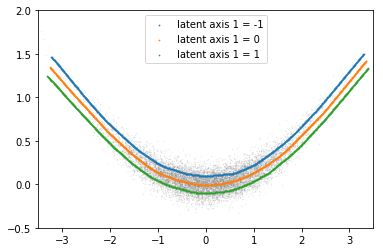

In [138]:
print("Latent space mapping for beta = ",beta,":")
plot_latent_map(decoder,valid_data,long_axis=0)

Looking like a very well regulated latent space

### beta = 0.1

Now we get to the point at which the regular training was having a lot of trouble

In [130]:
beta = 0.1
history = vae.fit(x=[train_data,np.ones(len(train_data))*beta], y=train_data, batch_size=100,
                epochs=1,verbose=1,
                validation_data = ([valid_data,np.ones(len(valid_data))*beta],valid_data),
                callbacks = callbacks
              )

Train on 100000 samples, validate on 10000 samples
Epoch 1/1
100000/100000 [==============================] - 13s 130us/step - loss: 0.2473 - val_loss: 0.2431


Latent space encoding for beta = 0.1 :


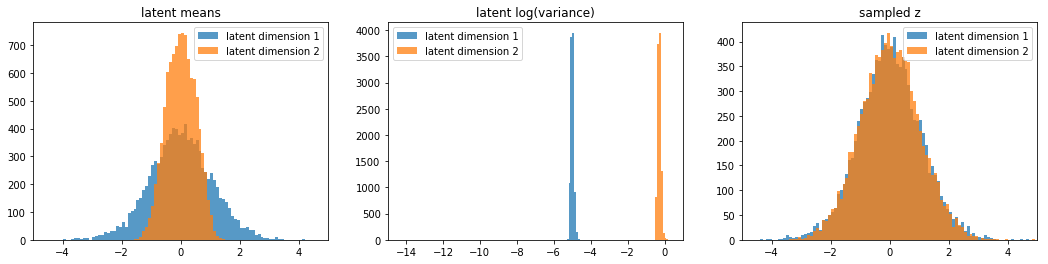

In [131]:
print("Latent space encoding for beta =",beta,":")
plot_latent_space(encoder,valid_data)

Latent distribution


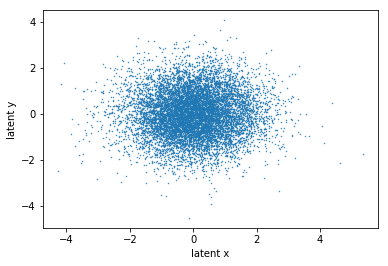

In [132]:
codes = encoder.predict(valid_data)
plt.scatter(codes[2][:,0],codes[2][:,1],s=0.2)
plt.xlabel("latent x")
plt.ylabel("latent y")
print("Latent distribution")
plt.show()

Latent space mapping for beta =  0.1 :


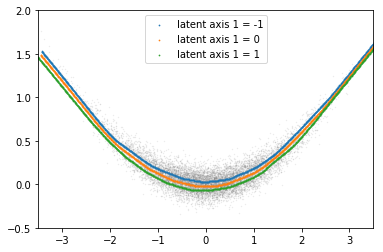

In [134]:
print("Latent space mapping for beta = ",beta,":")
plot_latent_map(decoder,valid_data,long_axis=0)

The girth is now marginal, but still present. The variance peaks at -0.5, just as I predicted in my earlier experiments.

### beta = 1

In [144]:
beta = 1.
history = vae.fit(x=[train_data,np.ones(len(train_data))*beta], y=train_data, batch_size=100,
                epochs=1,verbose=1,
                validation_data = ([valid_data,np.ones(len(valid_data))*beta],valid_data),
                callbacks = callbacks
              )

Train on 100000 samples, validate on 10000 samples
Epoch 1/1
100000/100000 [==============================] - 13s 131us/step - loss: 0.7544 - val_loss: 0.7677


Latent space encoding for beta = 1.0 :


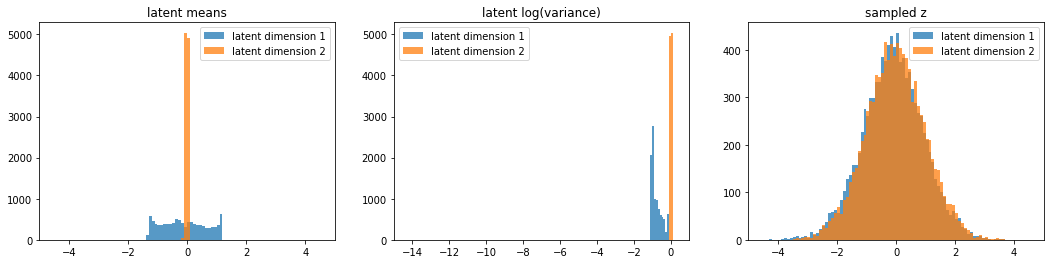

In [145]:
print("Latent space encoding for beta =",beta,":")
plot_latent_space(encoder,valid_data)

Latent distribution


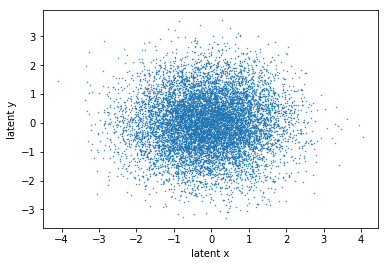

In [146]:
codes = encoder.predict(valid_data)
plt.scatter(codes[2][:,0],codes[2][:,1],s=0.2)
plt.xlabel("latent x")
plt.ylabel("latent y")
print("Latent distribution")
plt.show()

Latent space mapping for beta =  1.0 :


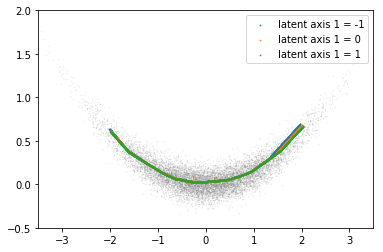

In [147]:
print("Latent space mapping for beta = ",beta,":")
plot_latent_map(decoder,valid_data,long_axis=0)

The girth is completely forgotten, and the length is becoming marginal too.

### beta = 3

In [148]:
beta = 3.
history = vae.fit(x=[train_data,np.ones(len(train_data))*beta], y=train_data, batch_size=100,
                epochs=1,verbose=1,
                validation_data = ([valid_data,np.ones(len(valid_data))*beta],valid_data),
                callbacks = callbacks
              )

Train on 100000 samples, validate on 10000 samples
Epoch 1/1
100000/100000 [==============================] - 13s 129us/step - loss: 0.8249 - val_loss: 0.8269


Latent space encoding for beta = 3.0 :


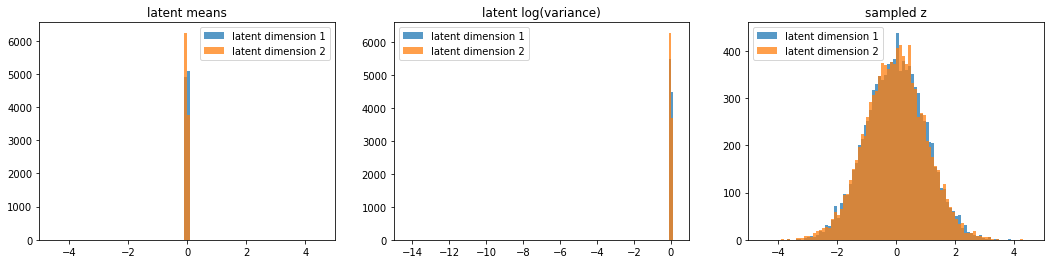

In [149]:
print("Latent space encoding for beta =",beta,":")
plot_latent_space(encoder,valid_data)

Latent distribution


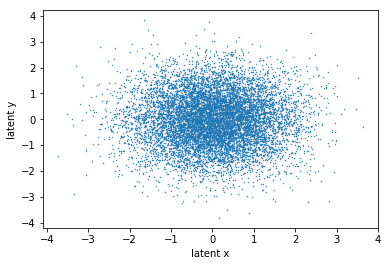

In [150]:
codes = encoder.predict(valid_data)
plt.scatter(codes[2][:,0],codes[2][:,1],s=0.2)
plt.xlabel("latent x")
plt.ylabel("latent y")
print("Latent distribution")
plt.show()

Latent space mapping for beta =  3.0 :


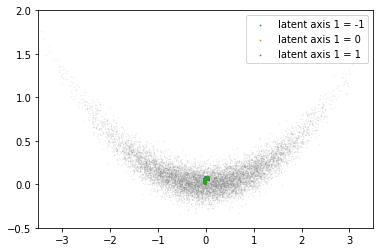

In [152]:
print("Latent space mapping for beta = ",beta,":")
plot_latent_map(decoder,valid_data,long_axis=0)

The VAE can no longer resolve anything in the banana and everything is mapped to a point.